In [23]:
import pandas as pd


# We saved our collected data in text files and now want to combine them into a useful dataframe.
def parse_recipes(file_path, label):
    recipes = []
    with open(file_path, 'r') as file:
        content = file.read()
        raw_recipes = content.strip().split('\n\n')
        
        for raw_recipe in raw_recipes:
            title, ingredients, instructions = None, None, None
            
            if 'Recipe:' in raw_recipe:
                sections = raw_recipe.split('Ingredients:')
                if len(sections) > 1:
                    title = sections[0].replace('Recipe:', '').strip()
                    ingredients_instructions = sections[1].split('Instructions:')
                    if len(ingredients_instructions) > 1:
                        ingredients = ingredients_instructions[0].strip()
                        instructions = ingredients_instructions[1].strip()
            
            if title and ingredients and instructions:
                recipes.append({
                    'title': title,
                    'ingredients': ingredients,
                    'instructions': instructions,
                    'label': label
                })
    
    return recipes

# We labeled the data manually.
regular_recipes = parse_recipes('recipes_data/regular_recipes.txt', 'regular')
fitness_recipes = parse_recipes('recipes_data/fitness_recipes.txt', 'fitness')


all_recipes = regular_recipes + fitness_recipes
df = pd.DataFrame(all_recipes)


df.to_csv('labeled_recipes.csv', index=False)

print("Data prepared for modeling:")
df.head()

Data prepared for modeling:


,title,ingredients,instructions,label
0,Best Meatloaf,2 pounds ground beef\n¼ cup bread crumbs (1 sl...,Preheat oven to 375°F (175°C).\nCombine ketchu...,regular
1,Chicken Lo Mein,1 pound chicken breasts\n8 ounces dry lo mein ...,"In a small bowl, whisk together sauce ingredie...",regular
2,Easy Homemade Mac and Cheese,8 ounces elbow macaroni uncooked\nCheese Sauce...,Cook elbow macaroni according to package instr...,regular
3,Chocolate Cake,1 ¼ cups all-purpose flour\n1 ¼ cups granulate...,Preheat oven to 350 degrees F.\nLine two 6” ro...,regular
4,Crock Pot Teriyaki Chicken,2 pounds chicken breasts\n½ cup honey\n¾ cup s...,Grease the container of a large slow cooker.\n...,regular


In [25]:
import pandas as pd
import re
from fractions import Fraction


unit_conversion = {
    'pounds': 453.592,   # pounds to grams
    'cup': 240,          # cups to ml
    'tablespoon': 15,    # tablespoon to ml
    'teaspoon': 5,       # teaspoon to ml
    'ounce': 28.3495     # ounces to grams
}


# We have ingredient amounts represented as fractions (e.g., 1/3, 1/2) in our dataset and want to convert them to floats.
def convert_fraction(quantity_str):
    try:
        if '/' in quantity_str:
            return float(sum(Fraction(s) for s in quantity_str.split()))
        return float(quantity_str)
    except ValueError:
        return None


# We normalized the recipes since some used metrics and others used the imperial system.
def normalize_units(quantity, unit):
    if unit in unit_conversion:
        return quantity * unit_conversion[unit]
    return quantity


# This function extracts quantities, units, and ingredient names from a multi-line text using a regular expression, normalizing the quantities accordingly. 
# It returns a list of dictionaries with each ingredient's name and normalized quantity.
def process_and_normalize_ingredients(ingredient_text):
    lines = ingredient_text.split('\n')
    ingredients_data = []
    
    for line in lines:
        match = re.match(r"(\d+\s*\d*\/?\d*)\s*(\w+)?\s*([\w\s]+)", line)
        if match:
            quantity_str = match.group(1).strip()
            quantity = convert_fraction(quantity_str) if quantity_str else None
            unit = match.group(2).strip() if match.group(2) else ''
            ingredient = match.group(3).strip()
        
            if quantity is not None and unit:
                quantity = normalize_units(quantity, unit.lower())
            
            ingredients_data.append({
                'ingredient': ingredient,
                'quantity': quantity
            })
    
    return ingredients_data

expanded_rows = []

for _, row in df.iterrows():
    normalized_ingredients = process_and_normalize_ingredients(row['ingredients'])
    for ingredient_data in normalized_ingredients:
        expanded_rows.append({
            'title': row['title'],
            'label': row['label'],
            'ingredient': ingredient_data['ingredient'],
            'quantity': ingredient_data['quantity']
        })


expanded_df = pd.DataFrame(expanded_rows)
pivot_df = expanded_df.pivot_table(index=['title', 'label'], columns='ingredient', values='quantity', aggfunc='sum').fillna(0).reset_index()
print(pivot_df)


ingredient                                              title    label       \
0                                     Air Fryer Eggplant Parm  fitness  0.0   
1                                        Air Fryer Pork Chops  fitness  4.0   
2           Air Fryer Spinach and Artichoke Stuffed Chicke...  fitness  5.0   
3                                                   Apple Pie  regular  0.0   
4                                               Apple pancake  fitness  0.0   
..                                                        ...      ...  ...   
107                                             Tuna burritos  fitness  0.0   
108                                           Vanilla oatmeal  fitness  0.0   
109                                          Vanilla pancakes  fitness  0.0   
110                              White Cheese Chicken Lasagna  regular  2.0   
111                                Whole30 Bacon and Egg Cups  fitness  0.0   

ingredient  100    2  American cheese  Cajun season

In [26]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# This function cleans text by replacing newlines with spaces, removing non-alphanumeric characters (except spaces), and converting everything to lowercase. 
def clean_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

for col in pivot_df.columns:
    if col not in ['label']:
        pivot_df[col] = pivot_df[col].astype(str).apply(clean_text)

vectorized_features = []
for col in pivot_df.columns:
    if col not in ['label']:
        vectorizer = TfidfVectorizer(max_features=50)   # We tried using max_features set to 100, but it resulted in lower accuracy.
        vectorized_col = vectorizer.fit_transform(pivot_df[col]).toarray()
        vectorized_features.append(pd.DataFrame(vectorized_col, index=pivot_df.index))

X_combined = pd.concat(vectorized_features, axis=1)
y = pivot_df['label'].apply(lambda x: 1 if x == 'fitness' else 0)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)


Model Accuracy: 0.6956521739130435
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.42      0.59        12
           1       0.61      1.00      0.76        11

    accuracy                           0.70        23
   macro avg       0.81      0.71      0.67        23
weighted avg       0.81      0.70      0.67        23



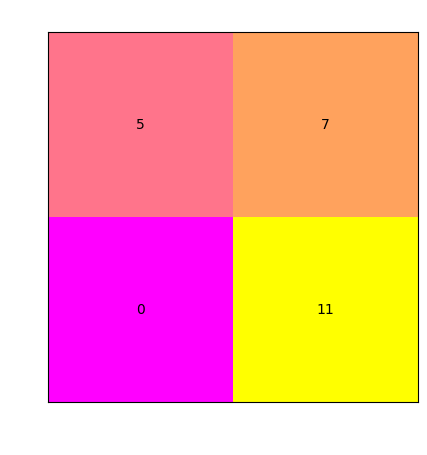

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='spring', ax=ax, colorbar=False)


fig.patch.set_alpha(0)  
ax.patch.set_alpha(0)  


for text in ax.texts:  
    text.set_color("black") 

plt.title('Confusion Matrix', color='white') 

ax.xaxis.label.set_color("white") 
ax.yaxis.label.set_color("white")
ax.tick_params(colors="white")

plt.show()

In [28]:
train_acc = nb_model.score(X_train, y_train)
val_acc = nb_model.score(X_test, y_test)
print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

Training Accuracy: 0.9887640449438202
Validation Accuracy: 0.6956521739130435
